In [1]:
import unicodedata
import string
import re
import random
import numpy as np
import time
import os
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from io import open
from copy import deepcopy


import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
SOS_token = 0
EOS_token = 1

In [4]:
class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.word2count = {}
        self.n_words = 2
    
    def add_sentence(self, sentence):
        for word in sentence.split(" "):
            self.add_word(word)
    
    def add_word(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1


class EncoderS2S(nn.Module):
    def __init__(self, input_size, hidden_size):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
    
    def forward(self, x, h0):
        embedded = self.embedding(x).view(1, 1, -1)
        x = embedded
        x, h = self.gru(x, h0)
        return x, h
    
    def zero_hidden(self, device):
        return torch.zeros(1, 1, self.hidden_size, device=device)


# TODO: try training a simple seq-to-seq model
class DecoderS2S(nn.Module):
    def __init__(self, input_size, hidden_size):
        super().__init__()
        # Input & output size are the same (since they are word embeddings)
        self.input_size = input_size
        self.output_size = input_size
        self.hidden_size = hidden_size
        
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, self.output_size)
        self.softmax = nn.LogSoftmax(dim=1)
        
    def forward(self, x, h0):
        embedded = self.embedding(x).view(1, 1, -1)
        x = F.relu(embedded)
        x, h = self.gru(x, h0)
        # GRU output has leading batch dimension, so index x[0]
        x = self.out(x[0])
        x = self.softmax(x)
        return x
    
    def zero_hidden(self, device):
        return torch.zeros(1, 1, self.hidden_size, device=device)

    
class AttnDecoderS2S(nn.Module):
    def __init__(self, input_size, hidden_size, max_length, dropout_p=0.1):
        super().__init__()
        self.input_size = input_size
        self.output_size = input_size
        self.hidden_size = hidden_size
        self.dropout_p = dropout_p
        self.max_length = max_length
        
        self.embedding = nn.Embedding(self.input_size, self.hidden_size)
        # Weights for each word in sentence of max length
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(p = self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)
        
    def forward(self, x, h0, yhats_encoder):
        embedded = self.embedding(x).view(1, 1, -1)
        embedded = self.dropout(embedded)
        
        x = torch.concat((embedded[0], h0[0]), dim=1)
        attn_weights = F.softmax(
            self.attn(x),
            dim=1
        )
        
        # unsqueeze(0) --> add 'batch' dimension back to
        # attention weights & add to encoder outputs
        attn_applied = torch.bmm(
            attn_weights.unsqueeze(0),
            yhats_encoder.unsqueeze(0)
        )
        
        # subscript embedded & attn_applied to emove 'batch' dimension
        x = torch.concat((embedded[0], attn_applied[0]), dim=1)
        # unsqueeze result to add 'batch' dimension back in
        x = self.attn_combine(x).unsqueeze(0)
        x = F.relu(x)
        
        x, h = self.gru(x, h0)
        # GRU output has leading batch dimension, so index x[0]
        x = self.out(x[0])
        x = F.log_softmax(x, dim=1)
        return x, h, attn_weights
    
    def zero_hidden(self, device):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [5]:
def unicode_to_ascii(s):
    """Turn a Unicode string to plain ASCII.
    """
    return "".join(
        c for c in unicodedata.normalize("NFD", s)
        if unicodedata.category(c) != "Mn"
    )


def normalize_string(s):
    """Lowercase, trim, and remove non-letter characters.
    """
    s = unicode_to_ascii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s


def read_langs(lang1, lang2, data_path="../data/rnn_seq_to_seq_data", reverse=False):
    print("Reading lines...")
    
    # Read file & split into lines
    lines = open(f"{data_path}/{lang1}-{lang2}.txt", encoding="utf-8").read().strip().split('\n')
    
    # Split every line into pairs and normalize
    pairs = [[normalize_string(s) for s in l.split('\t')] for l in lines]
    
    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)
        
    return input_lang, output_lang, pairs


def filter_pair(p, max_length, eng_prefixes):
    return len(p[0].split(" ")) < max_length and \
        len(p[1].split(" ")) < max_length and \
        p[1].startswith(eng_prefixes)


def filter_pairs(pairs, max_length, eng_prefixes):
    return [pair for pair in pairs if filter_pair(pair, max_length, eng_prefixes)]


def prepare_data(lang1, lang2, max_length, eng_prefixes, reverse=False):
    input_lang, output_lang, pairs = read_langs(lang1, lang2, reverse=reverse)
    print(f"Read {len(pairs)} sentence pairs")
    pairs = filter_pairs(pairs, max_length, eng_prefixes)
    print(f"Trimmed to {len(pairs)} sentence pairs")
    print("Counting words...")
    for pair in pairs:
        input_lang.add_sentence(pair[0])
        output_lang.add_sentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs


def indexes_from_sentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(" ")]


def tensor_from_sentence(lang, sentence, device):
    indexes = indexes_from_sentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)


def tensors_from_pairs(pair, input_lang, output_lang, device):
    input_tensor = tensor_from_sentence(input_lang, pair[0], device)
    target_tensor = tensor_from_sentence(output_lang, pair[1], device)
    return input_tensor, target_tensor


def as_minutes(s):
    m = int(np.round(s // 60))
    s = int(np.round(s % 60))
    return f"{m}m {s}s"


def time_since(since, percent):
    now = time.time()
    s = now - since
    es = s / percent
    rs = es - s
    return f"{as_minutes(s)} (- {as_minutes(rs)})"


def train(encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, input_tensor, target_tensor, max_length, device, teacher_forcing_ratio=0.5):
    h_encoder = encoder.zero_hidden(device)
    
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()
    
    input_length = input_tensor.shape[0]
    target_length = target_tensor.shape[0]
    
    yhats_encoder = torch.zeros(max_length, encoder.hidden_size, device=device)
    
    loss = 0.0
    for ei in range(input_length):
        yhat_encoder, h_encoder = encoder(input_tensor[ei], h_encoder)
        yhats_encoder[ei] = yhat_encoder[0, 0]
        
    x_decoder = torch.tensor([[SOS_token]], device=device)
    h_decoder = h_encoder
    
    use_teacher_forcing = True if np.random.uniform() < teacher_forcing_ratio else False
    
    # Teacher forcing = feed target in as next input
    if use_teacher_forcing:
        for di in range(target_length):
            # Pass in full encoder output
            yhat_decoder, h_decoder, attn_decoder = decoder(x_decoder, h_decoder, yhats_encoder)
            loss += criterion(yhat_decoder, target_tensor[di])
            
            x_decoder = target_tensor[di]
    # Non-teacher forcing = feed previous output of decoder as input
    else:
        for di in range(target_length):
            yhat_decoder, h_decoder, attn_decoder = decoder(x_decoder, h_decoder, yhats_encoder) 
            loss += criterion(yhat_decoder, target_tensor[di])
            
            topv, topi = yhat_decoder.topk(1)
            # When used as input, should be detached from backprop history
            x_decoder = topi.squeeze().detach()
            if x_decoder.item() == EOS_token:
                break
    
    loss.backward()
    
    encoder_optimizer.step()
    decoder_optimizer.step()
    
    return loss.item() / target_length


def train_iters(encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, n_iters, input_lang, output_lang, max_length, device, teacher_forcing_ratio=0.5, print_every=1000, plot_every=100):
    start_time = time.time()
    plot_losses = []
    # Reset by print_every
    print_loss_total = 0.0
    # Reset by plot_every
    plot_loss_total = 0.0
    
    encoder.train()
    decoder.train()
    training_pairs = [tensors_from_pairs(random.choice(pairs), input_lang, output_lang, device) for _ in range(n_iters)]
    for itr in range(1, n_iters + 1):
        input_tensor, target_tensor = training_pairs[itr - 1]
        
        loss = train(encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, input_tensor, target_tensor, max_length, device, teacher_forcing_ratio)
        print_loss_total += loss
        plot_loss_total += loss
        
        if itr % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0.0
            print(f"{time_since(start_time, itr / n_iters)} ({itr}, {np.round(itr / n_iters * 100, 1)}) {np.round(print_loss_avg, 3)}")
        
        if itr % plot_every == 0:
            # TODO
            pass


def evaluate(encoder, decoder, sentence, input_lang, output_lang, max_length, device):
    encoder.eval()
    decoder.eval()
    with torch.no_grad():
        input_tensor = tensor_from_sentence(input_lang, sentence, device)
        input_length = input_tensor.shape[0]
        h_encoder = encoder.zero_hidden(device)
        
        yhats_encoder = torch.zeros(max_length, encoder.hidden_size, device=device)
        
        for ei in range(input_length):
            yhat_encoder, h_encoder = encoder(input_tensor[ei], h_encoder)
            yhats_encoder[ei] += yhat_encoder[0, 0]
            
        x_decoder = torch.tensor([[SOS_token]], device=device)
        h_decoder = h_encoder
        
        decoded_words = []
        attns_decoder = torch.zeros(max_length, max_length)
        
        # TODO: implement beam search
        for di in range(max_length):
            yhat_decoder, h_decoder, attn_decoder = decoder(x_decoder, h_decoder, yhats_encoder)
            attns_decoder[di] = attn_decoder.detach()
            
            topv, topi = yhat_decoder.detach().topk(1)
            if topi.item() == EOS_token:
                decoded_words.append("<EOS>")
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])
                
            x_decoder = topi.squeeze().detach()
            
        return decoded_words, attns_decoder[:di + 1]

    
def evaluate_beam(encoder, decoder, sentence, input_lang, output_lang, max_length, device, k=3, n=1):
    encoder.eval()
    decoder.eval()
    with torch.no_grad():
        # Get encoder output
        input_tensor = tensor_from_sentence(input_lang, sentence, device)
        input_length = input_tensor.shape[0]
        h_encoder = encoder.zero_hidden(device)
        
        yhats_encoder = torch.zeros(max_length, encoder.hidden_size, device=device)
        
        for ei in range(input_length):
            yhat_encoder, h_encoder = encoder(input_tensor[ei], h_encoder)
            yhats_encoder[ei] += yhat_encoder[0, 0]
        
        x_decoder = torch.tensor([[SOS_token]], device=device)
        h_decoder = h_encoder
    
    # Store (output so far, next input, hidden state, attention, length, score)
    top_k = []
    # Get initial candidates
    with torch.no_grad():
        attns_decoder = torch.zeros(max_length, max_length)
        yhat_decoder, h_decoder, attn_decoder = decoder(x_decoder, h_decoder, yhats_encoder)
        attns_decoder[0] = attn_decoder.detach()
        
        topv, topi = yhat_decoder.squeeze().detach().topk(k)
        for i, ti in enumerate(topi):
            decoded_words = []
            if ti.item() == EOS_token:
                decoded_words.append("<EOS>")
            else:
                decoded_words.append(output_lang.index2word[ti.item()])
            top_k.append(
                (decoded_words, ti.squeeze().detach(), h_decoder, attns_decoder, 1, topv[i].item())
            )
    # top_k = sorted(top_k, key=lambda x: x[-1], reverse=True)
    # print(f"State at step 1")
    # for item in top_k:
    #     print(item[0])
    
    for di in range(1, max_length):
        top_k_new = []
        for decoded_words, x_decoder, h_decoder, attns_decoder, length, score in top_k:
            if decoded_words[-1] == "<EOS>":
                top_k_new.append(
                    (decoded_words, x_decoder, h_decoder, attns_decoder, length, score)
                )
                continue

            yhat_decoder, h_decoder, attn_decoder = decoder(x_decoder, h_decoder, yhats_encoder)
            attns_decoder[di] = attn_decoder.detach()
            
            topv, topi = yhat_decoder.squeeze().detach().topk(k)
            for i, ti in enumerate(topi):
                decoded_words_copy = deepcopy(decoded_words)
                if ti.item() == EOS_token:
                    decoded_words_copy.append("<EOS>")
                else:
                    decoded_words_copy.append(output_lang.index2word[ti.item()])
                top_k_new.append(
                    (decoded_words_copy, ti.squeeze().detach(), h_decoder, torch.clone(attns_decoder), len(decoded_words_copy), score + topv[i].item())
                )
        top_k = sorted(
            top_k_new,
            key=lambda x: x[-1] / np.power(x[-2], 0.7),
            reverse=True
        )[:k]
        # print(f"State at step {di + 1}")
        # for item in top_k:
        #     print(item[0])
    return [(item[0], item[3][:len(item[0])]) for item in top_k[:n]]

def evaluate_rand(encoder, decoder, pairs, input_lang, output_lang, max_length, device, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print("=>", pair[0])
        print("==", pair[1])
        yhats, attns = evaluate(encoder, decoder, pair[0], input_lang, output_lang, max_length, device)
        output_sentence = ' '.join(yhats)
        print("<=", output_sentence)
        print('')
        
        
def show_attns(input_sentence, output_words, attns):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attns.numpy(), cmap="bone")
    fig.colorbar(cax)
    ax.set_xticklabels(
        [''] + input_sentence.split(' ') + ["<EOS>"],
        rotation=90
    )
    ax.set_yticklabels([''] + output_words)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()
    

def evaluate_and_show_attns(encoder, decoder, input_sentence, input_lang, output_lang, max_length, device):
    output_words, attns = evaluate(
        encoder,
        decoder,
        input_sentence,
        input_lang,
        output_lang,
        max_length,
        device
    )
    print(f"Input: {input_sentence}")
    print(f"Output: {' '.join(output_words)}")
    show_attns(input_sentence, output_words, attns)

In [6]:
MAX_LENGTH = 10

eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s ",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)

In [7]:
input_lang, output_lang, pairs = prepare_data("eng", "fra", MAX_LENGTH, eng_prefixes, reverse=True)

Reading lines...
Read 135842 sentence pairs
Trimmed to 10599 sentence pairs
Counting words...
Counted words:
fra 4345
eng 2803


In [8]:
hidden_size = 256
lr = 0.001
m = 0.9
n_iters = int(6e4)
# Use previous trained model
load_chkpt = False
chkpt_path = "../checkpoints/seq_to_seq_translation_attn.pth"

In [9]:
encoder = EncoderS2S(input_lang.n_words, hidden_size).to(device)
attn_decoder = AttnDecoderS2S(output_lang.n_words, hidden_size, MAX_LENGTH).to(device)

In [10]:
encoder_optimizer = optim.SGD(encoder.parameters(), lr=lr, momentum=m)
decoder_optimizer = optim.SGD(attn_decoder.parameters(), lr=lr, momentum=m)
# encoder_optimizer = optim.AdamW(encoder.parameters(), lr=lr)
# decoder_optimizer = optim.AdamW(attn_decoder.parameters(), lr=lr)

criterion = nn.NLLLoss()

In [11]:
if os.path.isfile(chkpt_path) and load_chkpt:
    checkpoint = torch.load(chkpt_path)
    encoder.load_state_dict(checkpoint["encoder_state_dict"])
    attn_decoder.load_state_dict(checkpoint["decoder_state_dict"])
    encoder_optimizer.load_state_dict(checkpoint["encoder_optimizer_state_dict"])
    decoder_optimizer.load_state_dict(checkpoint["decoder_optimizer_state_dict"])
    criterion = checkpoint["criterion"]
else:
    train_iters(
        encoder,
        attn_decoder,
        encoder_optimizer,
        decoder_optimizer,
        criterion,
        n_iters,
        input_lang,
        output_lang,
        MAX_LENGTH,
        device,
        print_every=int(n_iters/50)
    )
    checkpoint = {
        "encoder_state_dict": encoder.state_dict(),
        "decoder_state_dict": attn_decoder.state_dict(),
        "encoder_optimizer_state_dict": encoder_optimizer.state_dict(),
        "decoder_optimizer_state_dict": decoder_optimizer.state_dict(),
        "criterion": criterion
    }
    torch.save(checkpoint, chkpt_path)

0m 37s (- 30m 23s) (1200, 2.0) 3.433
1m 5s (- 25m 60s) (2400, 4.0) 2.869
1m 32s (- 24m 5s) (3600, 6.0) 2.65
1m 60s (- 22m 59s) (4800, 8.0) 2.576
2m 27s (- 22m 2s) (6000, 10.0) 2.463
2m 54s (- 21m 13s) (7200, 12.0) 2.322
3m 20s (- 20m 30s) (8400, 14.0) 2.257
3m 47s (- 19m 51s) (9600, 16.0) 2.18
4m 14s (- 19m 17s) (10800, 18.0) 2.052
4m 41s (- 18m 43s) (12000, 20.0) 1.969
5m 8s (- 18m 11s) (13200, 22.0) 1.939
5m 35s (- 17m 40s) (14400, 24.0) 1.886
6m 2s (- 17m 10s) (15600, 26.0) 1.833
6m 29s (- 16m 40s) (16800, 28.0) 1.781
6m 56s (- 16m 11s) (18000, 30.0) 1.742
7m 23s (- 15m 42s) (19200, 32.0) 1.662
7m 51s (- 15m 14s) (20400, 34.0) 1.63
8m 18s (- 14m 45s) (21600, 36.0) 1.593
8m 45s (- 14m 17s) (22800, 38.0) 1.491
9m 12s (- 13m 49s) (24000, 40.0) 1.481
9m 40s (- 13m 21s) (25200, 42.0) 1.405
10m 7s (- 12m 53s) (26400, 44.0) 1.387
10m 35s (- 12m 25s) (27600, 46.0) 1.329
11m 2s (- 11m 58s) (28800, 48.0) 1.303
11m 30s (- 11m 30s) (30000, 50.0) 1.282
11m 57s (- 11m 2s) (31200, 52.0) 1.295
12m 

In [12]:
evaluate_rand(encoder, attn_decoder, pairs, input_lang, output_lang, MAX_LENGTH, device)

=> il a peur de son grand pere .
== he is afraid of his grandfather .
<= he is afraid of father is father . <EOS>

=> que vous etes drole .
== you are hilarious .
<= you re a funny . <EOS>

=> je suis endurant .
== i m resilient .
<= i m resilient . <EOS>

=> elle est plus grande que lui .
== she s taller than him .
<= she is taller than he is . <EOS>

=> c est une femme determinee .
== she s a determined woman .
<= she s a determined woman . <EOS>

=> vous etes avec des amies .
== you re with friends .
<= you re with friends . <EOS>

=> je suis desole de vous avoir blessees .
== i m sorry i hurt you .
<= i m sorry i hurt you . <EOS>

=> ici c est moi le patron .
== i m in charge here .
<= i m in charge with here . <EOS>

=> je ne suis pas assez vieille .
== i m not old enough .
<= i m not old old . <EOS>

=> tu es incroyable .
== you re incredible .
<= you re amazing . <EOS>



Input: je suis trop froid .
Output: i m too busy . <EOS>


/tmp/ipykernel_408/529223710.py:298: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(
/tmp/ipykernel_408/529223710.py:302: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + output_words)


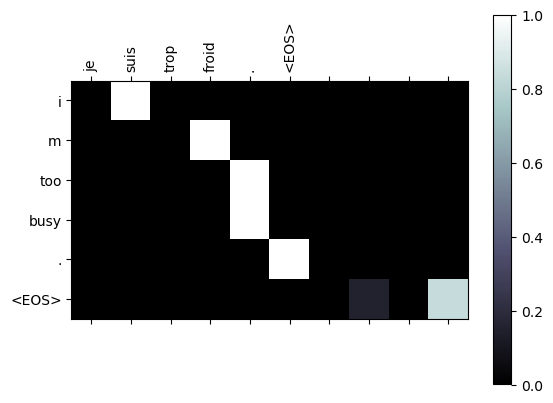

In [13]:
evaluate_and_show_attns(
    encoder,
    attn_decoder,
    "je suis trop froid .",
    # "je suis detendu .",
    input_lang,
    output_lang,
    MAX_LENGTH,
    device
)

Input: elle a cinq ans de moins que moi .
Output: she is five years younger than me . <EOS>


/tmp/ipykernel_408/529223710.py:298: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(
/tmp/ipykernel_408/529223710.py:302: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + output_words)


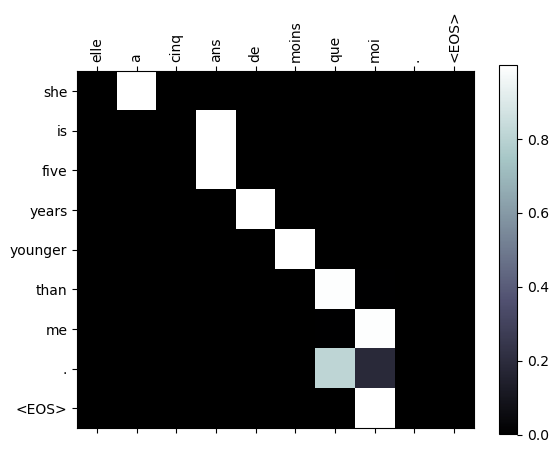

Input: elle est trop petit .
Output: she is too short . <EOS>


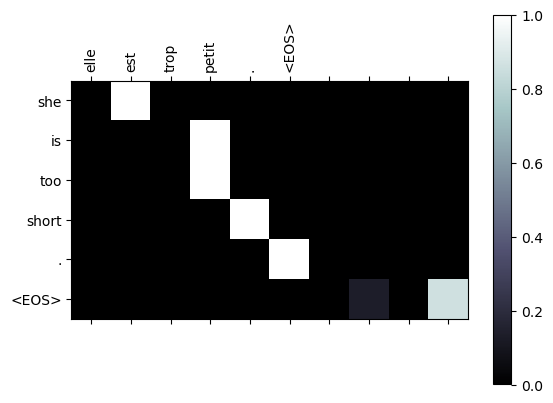

Input: je ne crains pas de mourir .
Output: i m not afraid of death . <EOS>


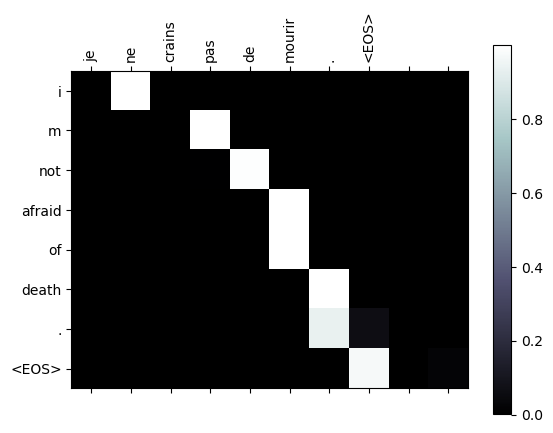

Input: c est un jeune directeur plein de talent .
Output: he s a very who who . . <EOS>


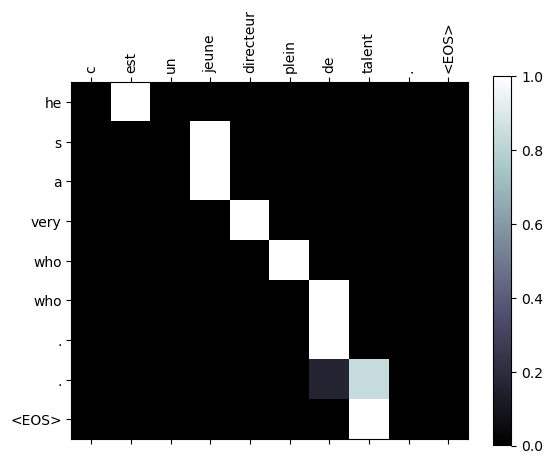

In [14]:
input_sentences = [
    "elle a cinq ans de moins que moi .",
    "elle est trop petit .",
    "je ne crains pas de mourir .",
    "c est un jeune directeur plein de talent ."
]

for inp_s in input_sentences:
    evaluate_and_show_attns(
        encoder,
        attn_decoder,
        inp_s,
        input_lang,
        output_lang,
        MAX_LENGTH,
        device
    )